In [1]:
# Import the libraries:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# Resize all the images to this 
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/Dataset/Train'
valid_path = '/content/drive/MyDrive/Dataset/Test'

In [4]:
# Import the vgg19 Library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

mobilenet = VGG19(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)

80142336/80134624 [==============================] - 1s 0us/step


In [5]:
# Don't train existing weights
for layer in mobilenet.layers:    # I want to freeze a pre-trained network in Keras
  layer.trainable = False

In [7]:
# usefull for getting numbers of classes
folder = glob('/content/drive/MyDrive/Dataset/Train/*')

In [8]:
folder

['/content/drive/MyDrive/Dataset/Train/Uninfected',
 '/content/drive/MyDrive/Dataset/Train/Parasite']

In [9]:
# our layers -- you can add more if you want
x = Flatten()(mobilenet.output)

In [10]:
mobilenet.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [11]:
x

<KerasTensor: shape=(None, 25088) dtype=float32 (created by layer 'flatten')>

In [12]:
7*7*512

25088

In [13]:
len(folder)

2

In [14]:
prediction = Dense(len(folder), activation='softmax')(x)

# Create a model boject
model = Model(inputs = mobilenet.input, outputs = prediction)

In [16]:
mobilenet.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [17]:
prediction

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense')>

In [18]:
# View the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
from tensorflow.keras.layers import MaxPooling2D

In [20]:
# Create a model from scratch using CNN

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape = (224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())

model.add(Dense(500, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0

In [22]:
# tell the model what cost and optimization method to use

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [23]:
#use the ImageDataGeneretor to import the imgaes from the dataset

from tensorflow.keras.preprocessing.image import ImageDataGenerator   # Generate batches of tensor image data with real-time data augmentation.

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
# Make sure you provide the same target size as intialize for the image size

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Dataset/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 416 images belonging to 2 classes.


In [25]:
training_set

In [26]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Dataset/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 134 images belonging to 2 classes.


In [27]:
# fit the model
# run the cell. It will take some time to execute

r = model.fit_generator(
    training_set,
    steps_per_epoch = len(training_set),
    epochs=50,
    verbose=1,
    validation_data = test_set,
    validation_steps = len(test_set)

)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
13/13 [==============================] - 258s 18s/step - loss: 2.0336 - accuracy: 0.5407 - val_loss: 0.7161 - val_accuracy: 0.4851
Epoch 2/50
13/13 [==============================] - 6s 488ms/step - loss: 0.5633 - accuracy: 0.6899 - val_loss: 1.2210 - val_accuracy: 0.3134
Epoch 3/50
13/13 [==============================] - 6s 492ms/step - loss: 0.5737 - accuracy: 0.6859 - val_loss: 0.8173 - val_accuracy: 0.5149
Epoch 4/50
13/13 [==============================] - 6s 487ms/step - loss: 0.5215 - accuracy: 0.7462 - val_loss: 1.4258 - val_accuracy: 0.3209
Epoch 5/50
13/13 [==============================] - 6s 484ms/step - loss: 0.5927 - accuracy: 0.6708 - val_loss: 0.7076 - val_accuracy: 0.5224
Epoch 6/50
13/13 [==============================] - 6s 483ms/step - loss: 0.4720 - accuracy: 0.7786 - val_loss: 0.9560 - val_accuracy: 0.4552
Epoch 7/50
13/13 [==============================] - 6s 488ms/step - loss: 0.4422 - accuracy: 0.7755 - val_loss: 0.8467 - val_accuracy: 0.5000
Epoch 

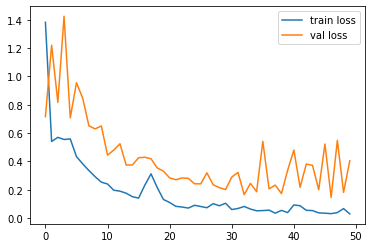

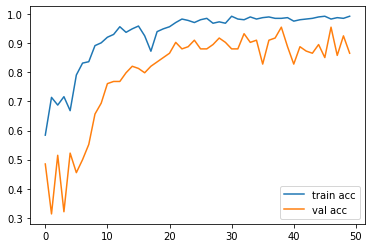

<Figure size 432x288 with 0 Axes>

In [28]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [29]:
# Save it as a h5 file

from tensorflow.keras.models import load_model
model.save('model_vgg19.h5')

In [30]:
y_pred = model.predict(test_set)

In [31]:
y_pred

array([[9.99969125e-01, 3.08295275e-05],
       [9.99989867e-01, 1.01299902e-05],
       [9.60132241e-01, 3.98678333e-02],
       [9.99999404e-01, 6.49473179e-07],
       [1.48170162e-02, 9.85182941e-01],
       [9.99986172e-01, 1.38119130e-05],
       [9.99565542e-01, 4.34500427e-04],
       [9.97679532e-01, 2.32044747e-03],
       [1.54239861e-02, 9.84575987e-01],
       [9.99989629e-01, 1.03543043e-05],
       [5.14287455e-03, 9.94857073e-01],
       [9.99911547e-01, 8.84115216e-05],
       [2.17343727e-03, 9.97826517e-01],
       [9.99997616e-01, 2.41625708e-06],
       [1.00000000e+00, 4.52851836e-08],
       [1.00000000e+00, 1.47421068e-11],
       [1.64710626e-01, 8.35289359e-01],
       [5.83276106e-03, 9.94167209e-01],
       [1.00000000e+00, 2.18323338e-16],
       [1.45827839e-03, 9.98541713e-01],
       [5.88221592e-04, 9.99411821e-01],
       [9.99521852e-01, 4.78214322e-04],
       [6.49858906e-04, 9.99350131e-01],
       [8.93371463e-01, 1.06628560e-01],
       [9.971764

In [47]:
import numpy as np
y_pred = np.argmax(y_pred, axis=0)

In [48]:
y_pred

0

In [38]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [49]:
model = load_model('model_vgg19.h5')

In [50]:
img=image.load_img('/content/drive/MyDrive/Dataset/Test/Uninfected/2.png',target_size=(224,224))

In [51]:
x=image.img_to_array(img)
x

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [42]:
x.shape

(224, 224, 3)

In [52]:
x=x/255

In [53]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [54]:

model.predict(img_data)

array([[0., 1.]], dtype=float32)

In [55]:
a=np.argmax(model.predict(img_data), axis=1)

In [56]:
if(a==1):
    print("Uninfected")
else:
    print("Infected")

Uninfected
